- recent update: 24.10.29
- update content:
    1. mid-price 생성
    2. significant or insignificant 예측 모델 생성
    3. significant 예측되는 경우에만 significant increase or decrease인지 예측
- target var: mid price return significant change (0 or 1)
- Model: XGBoost(significant or insignificant 예측) + LSTM(significant increase or decrease 예측)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
#from optuna.integration import XGBoostPruningCallback
#import optuna

In [3]:
df_origin = pd.read_csv('/content/drive/MyDrive/df_processed_2024_03_07to10_v2.csv')

In [4]:
df_origin.head()

,false.2,1_min_return,5_min_return,10_min_return,ask_price_1,ask_price_10,ask_price_11,ask_price_12,ask_price_13,ask_price_14,...,RSI25_midprice,return_vol_3_midprice,return_vol_10_midprice,return_vol_25_midprice,orderbook_imbalance,1_min_return_atbest,5_min_return_atbest,10_min_return_atbest,trade_count_for_one_minute,trade_volume_for_one_minute
0,2024-03-07 00:12:51.303000+00:00,0.000924,-0.000962,-0.003147,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000003,0.000003,0.000002,-0.206006,0.000534,0.000534,0.000534,277.0,5.726144
1,2024-03-07 00:12:51.503000+00:00,0.000924,-0.000962,-0.003152,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000000,0.000003,0.000002,-0.230908,0.000534,0.000534,0.000534,278.0,5.799944
2,2024-03-07 00:12:51.603000+00:00,0.000924,-0.000962,-0.003152,93620000,93663000,93666000,93668000,93669000,93670000,...,50.000000,0.000000,0.000002,0.000002,-0.230723,0.000534,0.000534,0.000534,276.0,5.746356
3,2024-03-07 00:12:51.703000+00:00,0.000395,-0.001491,-0.003681,93620000,93663000,93666000,93668000,93669000,93670000,...,97.115385,0.000305,0.000167,0.000106,-0.227128,0.000534,0.000534,0.000534,276.0,5.747256
4,2024-03-07 00:12:52.003000+00:00,0.000166,-0.001491,-0.003676,93620000,93663000,93666000,93668000,93669000,93670000,...,97.115385,0.000305,0.000167,0.000106,-0.226493,0.000534,0.000534,0.000534,274.0,5.734321


In [5]:
# 시간 타입으로 변경
df_origin['false.2'] = pd.to_datetime(df_origin['false.2'])

# 데이터프레임 리샘플링 - 'timestamp_column'을 타임스탬프 컬럼 이름으로 변경하세요
df_origin.set_index('false.2', inplace=True)  # 타임스탬프를 인덱스로 설정
df = df_origin.resample('1S').max()  # 1초 단위로 묶어서 평균값 계산

# 결과 확인
df.head(20)
print(df.shape)

df.reset_index(inplace=True)

<ipython-input-5-02badf86357e>:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df_origin.resample('1S').max()  # 1초 단위로 묶어서 평균값 계산


(431229, 105)


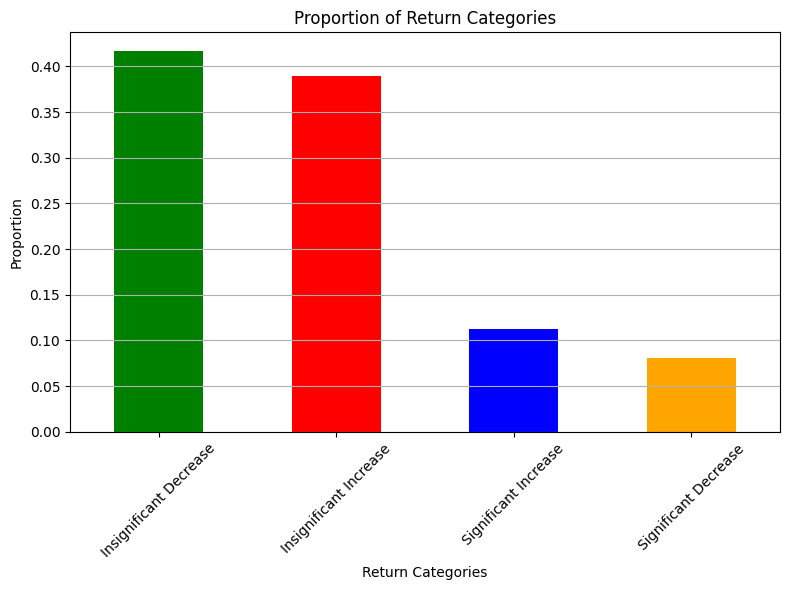

In [6]:
# 범주화 기준
threshold = 0.002

def categorize_return(value):
    if value >= threshold:
        return 'Significant Increase'
    elif value <= -threshold:
        return 'Significant Decrease'
    elif 0 <= value < threshold:
        return 'Insignificant Increase'
    else:
        return 'Insignificant Decrease'

# 범주화된 컬럼 추가
df['return_category'] = df['10_min_return'].apply(categorize_return)

# 카테고리 비율 계산
category_counts = df['return_category'].value_counts(normalize=True)

# 비율 시각화
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['green', 'red', 'blue', 'orange'])
plt.title('Proportion of Return Categories')
plt.ylabel('Proportion')
plt.xlabel('Return Categories')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
# 'significant increase'를 1로 설정, 나머지는 0
df['binary_target'] = df['return_category'].apply(lambda x: 1 if x == 'Significant Increase' else 0)

# 결과 확인
print(df['binary_target'].value_counts(normalize=True))

binary_target
0    0.887104
1    0.112896
Name: proportion, dtype: float64


In [8]:
print(list(df.columns))

['false.2', '1_min_return', '5_min_return', '10_min_return', 'ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12', 'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2', 'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6', 'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1', 'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13', 'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4', 'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9', 'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12', 'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2', 'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6', 'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1', 'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13', 'bid_size_14', 'bid_size_15', 'bid_size_2', 'bid_size_3', 'bid_size_4', 'bid_size_5', 'bid_size_6', 'bid_size_7', 'bid_size_8', 'bid_size_9', 'total_ask_size', 'total_bid_size', 'mid_pric

In [9]:
# NaN 값 개수 확인
print("NaN 값 개수 확인:")
print(df.isna().sum())  # 각 열별 NaN 값 개수 출력

# 전체 데이터프레임에서 NaN 값 총합
print("\n전체 NaN 값 총합:", df.isna().sum().max())

# NaN 값 제거
df = df.dropna()

# 제거 후 결과 확인
print("\nNaN 제거 후 데이터프레임 크기:", df.shape)

NaN 값 개수 확인:
false.2                            0
1_min_return                   13766
5_min_return                   14003
10_min_return                  14301
ask_price_1                    13707
                               ...  
10_min_return_atbest           13766
trade_count_for_one_minute     13766
trade_volume_for_one_minute    13766
return_category                    0
binary_target                      0
Length: 108, dtype: int64

전체 NaN 값 총합: 14301

NaN 제거 후 데이터프레임 크기: (416928, 108)


In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. 시계열 데이터 분할 (Train, Validation, Test)
train_size = int(len(df) * 0.7)
valid_size = int(len(df) * 0.15)

train_data = df[:train_size]
valid_data = df[train_size:train_size + valid_size]
test_data = df[train_size + valid_size:]

print(f"Train size: {len(train_data)}, Validation size: {len(valid_data)}, Test size: {len(test_data)}")

# 2. Standard Scaling
scaler = StandardScaler()

drop_cols = ['false.2', '1_min_return', '1_min_return_atbest', '5_min_return', '5_min_return_atbest',
             '10_min_return', '10_min_return_atbest', 'return_category', 'binary_target', 'mid_price_diff',
             'return_vol_3_midprice', 'return_vol_10_midprice', 'return_vol_25_midprice']

# Train 데이터의 Feature를 기준으로 Scaling
train_features = train_data.drop(columns=drop_cols)
valid_features = valid_data.drop(columns=drop_cols)
test_features = test_data.drop(columns=drop_cols)

# Scaling 수행
scaler.fit(train_features)  # Train 데이터만 기준으로 스케일링
X_train_scaled = scaler.transform(train_features)
X_valid_scaled = scaler.transform(valid_features)
X_test_scaled = scaler.transform(test_features)

y_train = train_data['binary_target'].values
y_valid = valid_data['binary_target'].values
y_test = test_data['binary_target'].values

# Sequence 길이 정의
sequence_length = 10
batch_size = 64

# 데이터셋 정의 (Sequence 지원)
class TimeSeriesDatasetWithSequence(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        # Sequence 길이에 맞게 데이터 크기를 조정
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        # Sequence 길이만큼 데이터 슬라이싱
        X_seq = self.X[idx:idx + self.sequence_length]
        y_seq = self.y[idx + self.sequence_length - 1]  # 마지막 시점의 y 값
        return X_seq, y_seq

# Train, Validation, Test Dataset 생성
train_dataset = TimeSeriesDatasetWithSequence(X_train_scaled, y_train, sequence_length)
valid_dataset = TimeSeriesDatasetWithSequence(X_valid_scaled, y_valid, sequence_length)
test_dataset = TimeSeriesDatasetWithSequence(X_test_scaled, y_test, sequence_length)

# DataLoader 생성
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Validation Loader Batches: {len(valid_loader)}")
print(f"Test Loader Batches: {len(test_loader)}")

# 오버샘플링 수행 함수
def oversample_time_series(dataset):
    # Sequence 데이터를 X, y로 분리
    all_X, all_y = [], []
    for X, y in dataset:
        all_X.append(X.numpy())
        all_y.append(y.item())

    all_X = np.array(all_X)
    all_y = np.array(all_y)

    # 클래스별 분포 확인
    class_counts = np.bincount(all_y.astype(int))
    max_class_count = class_counts.max()
    print(f"Original class distribution: {class_counts}")

    # 오버샘플링 수행
    oversampled_X, oversampled_y = [], []
    for cls in range(len(class_counts)):
        cls_indices = np.where(all_y == cls)[0]
        cls_samples = all_X[cls_indices]
        cls_labels = all_y[cls_indices]

        # 필요한 샘플 수만큼 복제하여 추가
        num_to_add = max_class_count - len(cls_indices)
        if num_to_add > 0:
            extra_indices = np.random.choice(cls_indices, size=num_to_add, replace=True)
            oversampled_X.extend(cls_samples)
            oversampled_X.extend(all_X[extra_indices])
            oversampled_y.extend(cls_labels)
            oversampled_y.extend(all_y[extra_indices])
        else:
            oversampled_X.extend(cls_samples)
            oversampled_y.extend(cls_labels)

    oversampled_X = np.array(oversampled_X)
    oversampled_y = np.array(oversampled_y)
    print(f"Oversampled class distribution: {np.bincount(oversampled_y.astype(int))}")

    return oversampled_X, oversampled_y

# Train 데이터 오버샘플링 수행
oversampled_X_train, oversampled_y_train = oversample_time_series(train_dataset)

# 오버샘플링 데이터로 Train Dataset 및 DataLoader 생성
train_dataset = TimeSeriesDatasetWithSequence(oversampled_X_train, oversampled_y_train, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# 확인
print(f"Train Loader Batches: {len(train_loader)}")


Train size: 291849, Validation size: 62539, Test size: 62540


NameError: name 'X_train_resampled' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score

# Binary Classification Model 정의
class BinaryClassificationLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(BinaryClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)  # Use hidden state from the last LSTM layer
        return self.fc(hidden[-1])

# Hyperparameters
hyperparams = {
    "input_dim": X_train_scaled.shape[1],  # Number of features
    "hidden_dim": 128,                    # LSTM hidden dimension
    "num_layers": 2,                      # Number of LSTM layers
    "dropout_rate": 0.5,                  # Dropout rate
    "batch_size": 64,                     # Batch size
    "epochs": 30,                         # Number of training epochs
    "learning_rate": 1e-3,                # Initial learning rate
    "weight_decay": 1e-5,                 # Weight decay for regularization
    "gradient_clipping": 1.0,             # Max norm for gradient clipping
}

# Model 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassificationLSTM(
    input_dim=hyperparams["input_dim"],
    hidden_dim=hyperparams["hidden_dim"],
    num_layers=hyperparams["num_layers"],
    dropout_rate=hyperparams["dropout_rate"]
).to(device)

# Loss function 및 Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training Loop
def train_model(model, train_loader, valid_loader, hyperparams):
    train_losses, valid_losses = [], []
    best_valid_loss = float("inf")
    patience_counter = 0

    for epoch in range(hyperparams["epochs"]):
        # Training Phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=hyperparams["gradient_clipping"])
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        valid_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item()
                all_preds.extend((y_pred > 0.5).cpu().numpy())  # Binary predictions
                all_targets.extend(y_batch.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Scheduler step
        scheduler.step(valid_loss)

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_binary_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= 5:  # Early stopping patience
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Performance metrics
        accuracy = accuracy_score(all_targets, all_preds)
        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, valid_losses

# Training 시작
train_losses, valid_losses = train_model(model, train_loader, valid_loader, hyperparams)

# Training 및 Validation Loss 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Testing
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_binary_model.pth"))
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).cpu().numpy())  # Binary predictions
            all_targets.extend(y_batch.cpu().numpy())

    print("\nTest Performance:")
    print(classification_report(all_targets, all_preds, digits=4))

# Test model
test_model(model, test_loader)

### 실제 데이터에 적용
- insignificant increase, decrease도 적용

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.